In [439]:
from preprocess import Parser
from classifier import DiscriminativeClassifier, BinaryGenerativeClassifier
from evaluation import calc_sd_auc, correlate_AUCs, calc_z_diff
import pandas as pd
from io import StringIO
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk import word_tokenize
import nltk
import re
import operator
from topicmodel import LDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score, auc, accuracy_score, confusion_matrix, roc_curve
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates


from wordcloud import WordCloud, STOPWORDS

import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator

In [3]:
cfnai = pd.read_excel('cfnai-data-series-xlsx.xlsx')
cfnai = cfnai[106:586].reset_index()

In [4]:
nber = pd.read_csv('nber.csv', parse_dates=['date'])
nber.tail()

,meeting,D_NBER,date
475,201508,0,NaT
476,201509,0,2015-09-17
477,201510,0,2015-10-28
478,201511,0,NaT
479,201512,0,2015-12-16


In [288]:
theta_train = pd.read_csv('theta_train.csv')
theta_test = pd.read_csv('theta_test.csv')

In [229]:
theta_train_gen = pd.read_csv('theta_train_gen.csv').iloc[:,1:]
theta_test_gen = pd.read_csv('theta_test_gen.csv').iloc[:,1:]

In [230]:
theta_train_gen.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000076,0.000092,0.000075,0.000077,0.000074,0.000075,0.000074,0.000074,0.000074,0.000075,...,0.000074,0.000213,0.000074,0.000074,0.000086,0.000075,0.000075,0.000074,0.000091,0.000074
1,0.000071,0.000087,0.000070,0.000073,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070,...,0.000070,0.000201,0.000070,0.000070,0.000081,0.000070,0.000071,0.000070,0.070641,0.000070
2,0.000058,0.000071,0.000057,0.000059,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,...,0.000057,0.000163,0.000057,0.000057,0.000066,0.000057,0.000058,0.000057,0.000069,0.000057
3,0.000086,0.000105,0.000085,0.000088,0.000084,0.000085,0.000084,0.000084,0.000084,0.000085,...,0.000084,0.000242,0.000084,0.000084,0.000098,0.000085,0.000085,0.000084,0.000103,0.000084
4,0.000086,0.000105,0.000085,0.000088,0.000084,0.000085,0.000084,0.000084,0.000084,0.000085,...,0.000084,0.000242,0.000084,0.000084,0.000098,0.000085,0.000085,0.000084,0.000103,0.000084


In [6]:
macro_data = pd.concat([nber, cfnai], axis=1)
macro_data.tail()

,meeting,D_NBER,date,index,Date,P_I,EU_H,C_H,SO_I,CFNAI,CFNAI_MA3,DIFFUSION
475,201508,0,NaT,581,2015-08-31,-0.10,-0.07,-0.09,-0.08,-0.33,-0.04,-0.07
476,201509,0,2015-09-17,582,2015-09-30,-0.27,-0.09,-0.06,0.15,-0.27,-0.09,-0.12
477,201510,0,2015-10-28,583,2015-10-31,-0.10,0.12,-0.11,-0.07,-0.17,-0.26,-0.28
478,201511,0,NaT,584,2015-11-30,-0.29,0.07,-0.06,-0.08,-0.37,-0.27,-0.27
479,201512,0,2015-12-16,585,2015-12-31,-0.33,0.11,-0.04,-0.04,-0.31,-0.28,-0.22


In [7]:
data = pd.read_table(StringIO(''.join(l.replace('\u2028', ' ') for l in open('minutes_data.txt'))))
grouped_data = data.groupby('meeting', as_index=False)
full_minutes = pd.concat([grouped_data['text'].apply(' '.join), grouped_data.first()], axis=1)
full_minutes.drop(['text', 'seq'], axis=1, inplace=True)
full_minutes.rename(columns={0: 'text'}, inplace=True)
full_minutes.head()


,text,meeting,D_NBER
0,"By unanimous vote, the Federal Reserve Bank o...",197601,0
1,"By unanimous vote, the Federal Reserve Bank o...",197602,0
2,"By unanimous vote, the Federal Reserve Bank o...",197603,0
3,"By unanimous vote, the Federal Reserve Bank o...",197604,0
4,"With Mr. Coldwell, dissenting, the Federal Re...",197605,0


In [120]:
nber['meeting'] = nber['meeting'].astype(str)
full_minutes['meeting'] = full_minutes['meeting'].astype(str)

cfnai_nber = pd.concat([cfnai, nber['meeting'], nber['D_NBER'].shift(-1), 
                       nber['D_NBER'].shift(-3), nber['D_NBER'].shift(-6),
                        nber['D_NBER'].shift(-12), nber['D_NBER'].shift(-24),
                       nber['date']], 
                      axis=1)
cfnai_nber.columns = list(cfnai.columns) + ['meeting', 'D_NBER_1', 'D_NBER_3', 'D_NBER_6',
                                            'D_NBER_12', 'D_NBER_24',
                                            'meeting_date']

macro_data = pd.merge(full_minutes, cfnai_nber, how='inner', on='meeting')

macro_data.head()

,text,meeting,D_NBER,index,Date,P_I,EU_H,C_H,SO_I,CFNAI,CFNAI_MA3,DIFFUSION,D_NBER_1,D_NBER_3,D_NBER_6,D_NBER_12,D_NBER_24,meeting_date
0,"By unanimous vote, the Federal Reserve Bank o...",197601,0,106,1976-01-31,0.72,0.95,0.12,0.44,2.23,1.23,0.62,0.0,0.0,0.0,0.0,0.0,1976-01-20
1,"By unanimous vote, the Federal Reserve Bank o...",197602,0,107,1976-02-29,0.55,0.62,-0.02,0.19,1.34,1.61,0.77,0.0,0.0,0.0,0.0,0.0,1976-02-18
2,"By unanimous vote, the Federal Reserve Bank o...",197603,0,108,1976-03-31,0.02,0.36,0.04,0.17,0.59,1.39,0.66,0.0,0.0,0.0,0.0,0.0,1976-03-16
3,"By unanimous vote, the Federal Reserve Bank o...",197604,0,109,1976-04-30,0.27,0.23,0.08,0.07,0.64,0.86,0.53,0.0,0.0,0.0,0.0,0.0,1976-04-20
4,"With Mr. Coldwell, dissenting, the Federal Re...",197605,0,110,1976-05-31,0.24,0.15,-0.10,0.05,0.34,0.52,0.37,0.0,0.0,0.0,0.0,0.0,1976-05-18


In [121]:
train = macro_data[:200]
test = macro_data[200:].reset_index()

In [109]:
# train_features = pd.concat([train[['P_I', 'EU_H', 'C_H', 'SO_I',
#                        'CFNAI', 'CFNAI_MA3', 'DIFFUSION']],
#                             theta_train], axis=1)

# test_features = pd.concat([test[['P_I', 'EU_H', 'C_H', 'SO_I',
#                        'CFNAI', 'CFNAI_MA3', 'DIFFUSION']],
#                             theta_test], axis=1)

train_features = pd.concat([train[['CFNAI_MA3']],
                            theta_train], axis=1)

test_features = pd.concat([test[['CFNAI_MA3']],
                            theta_test], axis=1)

In [11]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [17]:
rec = pd.read_csv('recs.csv', parse_dates=['Peak', 'Trough'])[1:]
rec.head()

,Peak,Trough
1,1980-01-01,1980-07-01
2,1981-07-01,1982-11-01
3,1990-07-01,1991-03-01
4,2001-03-01,2001-11-01
5,2007-12-01,2009-06-01


In [19]:
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,23 hours 43 mins
H2O cluster version:,3.10.4.4
H2O cluster version age:,"21 days, 6 hours and 55 minutes"
H2O cluster name:,H2O_from_python_dkn22_618jik
H2O cluster total nodes:,1
H2O cluster free memory:,3.249 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [290]:
pd.concat([theta_train, train], axis=1).to_csv('train_df.csv', index=False)
pd.concat([theta_test, test], axis=1).to_csv('test_df.csv', index=False)

In [291]:
train_df = h2o.import_file('train_df.csv', header=1)
test_df = h2o.import_file('test_df.csv', header=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [313]:
sorted(logistic_h2o.coef().items(), key=lambda x:
x[1], reverse=True)

[('46', 123.2812555002436),
 ('26', 95.3504762704479),
 ('43', 95.14081822712555),
 ('20', 91.06853287710801),
 ('4', 58.294994179858286),
 ('47', 50.476131670307836),
 ('33', 49.62081933748572),
 ('38', 34.469337796247665),
 ('10', 32.53058224464772),
 ('44', 27.445632342882025),
 ('0', 26.44454479076392),
 ('16', 16.80517473684178),
 ('49', 15.919049570187983),
 ('7', 15.88458766238012),
 ('48', 12.13392711931384),
 ('14', 11.663845969400326),
 ('12', 9.876884709527738),
 ('1', 8.64606377008696),
 ('6', 6.175807999864572),
 ('24', 6.169491853281311),
 ('39', 5.430702735916985),
 ('15', 4.669782156631753),
 ('18', 0.6387936349069372),
 ('17', -0.1594621009442679),
 ('32', -0.850305653626918),
 ('36', -1.4102009256400119),
 ('45', -1.4600465398359754),
 ('40', -1.469808927459481),
 ('31', -2.036689118351359),
 ('41', -3.90508533030617),
 ('30', -4.0552463848973765),
 ('Intercept', -5.614421831589366),
 ('37', -5.791786268843928),
 ('29', -6.243340513805796),
 ('2', -9.373833317792855),

In [312]:
logistic_h2o.summary()

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,binomial,logit,Ridge ( lambda = 0.01568 ),50,50,6,train_df15.hex


In [84]:
test['D_NBER'].value_counts() / test.shape[0]

0    0.860656
1    0.139344
Name: D_NBER, dtype: float64

In [85]:
predictions_h2o = logistic_h2o.predict(test_df)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [322]:
all_predictions_topics = []
all_predictions_topics_CFNAI = []

In [323]:
for ycol in ['D_NBER','D_NBER_1', 'D_NBER_3', 'D_NBER_6',
            'D_NBER_12']:
    logistic_h2o = H2OGeneralizedLinearEstimator(alpha=0, family = "binomial"
                                                )
    logistic_h2o.train(y = ycol, x = list(range(50)), training_frame = train_df)
    predictions = logistic_h2o.predict(test_df)
    all_predictions_topics.append(predictions)
    name = "prediction " + ycol + "TopicsOnly.csv"
    h2o.export_file(predictions, name, force = True)
    
    print(logistic_h2o.model_performance(test_df))

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.12165448260895254
RMSE: 0.34879002653308844
LogLoss: 0.43682285659250886
Null degrees of freedom: 121
Residual degrees of freedom: 71
Null deviance: 99.51944846220036
Residual deviance: 106.58477700857216
AIC: 208.58477700857216
AUC: 0.8717086834733894
Gini: 0.7434173669467787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.028150852431434385: 


,0,1,Error,Rate
0,90.0,15.0,0.1429,(15.0/105.0)
1,3.0,14.0,0.1765,(3.0/17.0)
Total,93.0,29.0,0.1475,(18.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0281509,0.6086957,28.0
max f2,0.0220170,0.7352941,33.0
max f0point5,0.0765551,0.6140351,9.0
max accuracy,0.1142612,0.8934426,5.0
max precision,0.1885177,1.0,0.0
max recall,0.0066876,1.0,78.0
max specificity,0.1885177,1.0,0.0
max absolute_mcc,0.0281509,0.5537538,28.0
max min_per_class_accuracy,0.0281509,0.8235294,28.0
max mean_per_class_accuracy,0.0220170,0.8507003,33.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.1453500,3.5882353,3.5882353,0.5,0.5,0.0588235,0.0588235,258.8235294,258.8235294
,2,0.0245902,0.1392682,7.1764706,4.7843137,1.0,0.6666667,0.0588235,0.1176471,617.6470588,378.4313725
,3,0.0327869,0.1282271,7.1764706,5.3823529,1.0,0.75,0.0588235,0.1764706,617.6470588,438.2352941
,4,0.0409836,0.1157765,7.1764706,5.7411765,1.0,0.8,0.0588235,0.2352941,617.6470588,474.1176471
,5,0.0573770,0.1101569,3.5882353,5.1260504,0.5,0.7142857,0.0588235,0.2941176,258.8235294,412.6050420
,6,0.1065574,0.0705443,2.3921569,3.8642534,0.3333333,0.5384615,0.1176471,0.4117647,139.2156863,286.4253394
,7,0.1557377,0.0402725,2.3921569,3.3993808,0.3333333,0.4736842,0.1176471,0.5294118,139.2156863,239.9380805
,8,0.2049180,0.0344458,3.5882353,3.4447059,0.5,0.48,0.1764706,0.7058824,258.8235294,244.4705882
,9,0.3032787,0.0209657,1.7941176,2.9093800,0.25,0.4054054,0.1764706,0.8823529,79.4117647,190.9379968
,10,0.4016393,0.0149995,0.0,2.1968788,0.0,0.3061224,0.0,0.8823529,-100.0,119.6878752




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1346095656076651
RMSE: 0.3668917627961482
LogLoss: 0.6301223109297249
Null degrees of freedom: 121
Residual degrees of freedom: 71
Null deviance: 99.51944846220036
Residual deviance: 153.74984386685298
AIC: 255.74984386685298
AUC: 0.8039215686274509
Gini: 0.6078431372549018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.008493366752675648: 


,0,1,Error,Rate
0,90.0,15.0,0.1429,(15.0/105.0)
1,5.0,12.0,0.2941,(5.0/17.0)
Total,95.0,27.0,0.1639,(20.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0084934,0.5454545,26.0
max f2,0.0084934,0.6315789,26.0
max f0point5,0.0145206,0.5294118,16.0
max accuracy,0.0697301,0.8688525,0.0
max precision,0.0697301,1.0,0.0
max recall,0.0012472,1.0,99.0
max specificity,0.0697301,1.0,0.0
max absolute_mcc,0.0084934,0.4696813,26.0
max min_per_class_accuracy,0.0084934,0.7058824,26.0
max mean_per_class_accuracy,0.0084934,0.7815126,26.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.0509028,3.5882353,3.5882353,0.5,0.5,0.0588235,0.0588235,258.8235294,258.8235294
,2,0.0245902,0.0430494,0.0,2.3921569,0.0,0.3333333,0.0,0.0588235,-100.0,139.2156863
,3,0.0327869,0.0356540,0.0,1.7941176,0.0,0.25,0.0,0.0588235,-100.0,79.4117647
,4,0.0409836,0.0307715,7.1764706,2.8705882,1.0,0.4,0.0588235,0.1176471,617.6470588,187.0588235
,5,0.0573770,0.0301962,3.5882353,3.0756303,0.5,0.4285714,0.0588235,0.1764706,258.8235294,207.5630252
,6,0.1065574,0.0207137,2.3921569,2.7601810,0.3333333,0.3846154,0.1176471,0.2941176,139.2156863,176.0180995
,7,0.1557377,0.0135141,4.7843137,3.3993808,0.6666667,0.4736842,0.2352941,0.5294118,378.4313725,239.9380805
,8,0.2049180,0.0107260,1.1960784,2.8705882,0.1666667,0.4,0.0588235,0.5882353,19.6078431,187.0588235
,9,0.3032787,0.0061479,1.1960784,2.3275040,0.1666667,0.3243243,0.1176471,0.7058824,19.6078431,132.7503975
,10,0.4016393,0.0049585,0.0,1.7575030,0.0,0.2448980,0.0,0.7058824,-100.0,75.7503001




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.13177394708943704
RMSE: 0.36300681410882224
LogLoss: 0.5532316900479544
Null degrees of freedom: 121
Residual degrees of freedom: 71
Null deviance: 99.51944846220036
Residual deviance: 134.9885323717009
AIC: 236.9885323717009
AUC: 0.8005602240896359
Gini: 0.6011204481792718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.019851951614165215: 


,0,1,Error,Rate
0,96.0,9.0,0.0857,(9.0/105.0)
1,6.0,11.0,0.3529,(6.0/17.0)
Total,102.0,20.0,0.123,(15.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0198520,0.5945946,19.0
max f2,0.0182599,0.6382979,25.0
max f0point5,0.0198520,0.5670103,19.0
max accuracy,0.0198520,0.8770492,19.0
max precision,0.0476399,0.5714286,6.0
max recall,0.0023205,1.0,103.0
max specificity,0.0921451,0.9904762,0.0
max absolute_mcc,0.0198520,0.5250897,19.0
max min_per_class_accuracy,0.0115142,0.7523810,38.0
max mean_per_class_accuracy,0.0182599,0.7862745,25.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.0820848,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,2,0.0245902,0.0669557,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,3,0.0327869,0.0653544,7.1764706,1.7941176,1.0,0.25,0.0588235,0.0588235,617.6470588,79.4117647
,4,0.0409836,0.0596437,7.1764706,2.8705882,1.0,0.4,0.0588235,0.1176471,617.6470588,187.0588235
,5,0.0573770,0.0474456,7.1764706,4.1008403,1.0,0.5714286,0.1176471,0.2352941,617.6470588,310.0840336
,6,0.1065574,0.0321176,3.5882353,3.8642534,0.5,0.5384615,0.1764706,0.4117647,258.8235294,286.4253394
,7,0.1557377,0.0205112,3.5882353,3.7770898,0.5,0.5263158,0.1764706,0.5882353,258.8235294,277.7089783
,8,0.2049180,0.0187841,1.1960784,3.1576471,0.1666667,0.44,0.0588235,0.6470588,19.6078431,215.7647059
,9,0.3032787,0.0122340,0.5980392,2.3275040,0.0833333,0.3243243,0.0588235,0.7058824,-40.1960784,132.7503975
,10,0.4016393,0.0083828,1.1960784,2.0504202,0.1666667,0.2857143,0.1176471,0.8235294,19.6078431,105.0420168




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.14358412263559645
RMSE: 0.3789249564697428
LogLoss: 0.7613540753990617
Null degrees of freedom: 121
Residual degrees of freedom: 71
Null deviance: 104.21038206480068
Residual deviance: 185.7703943973712
AIC: 287.7703943973712
AUC: 0.42735042735042733
Gini: -0.14529914529914534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0004225935916309775: 


,0,1,Error,Rate
0,0.0,104.0,1.0,(104.0/104.0)
1,0.0,18.0,0.0,(0.0/18.0)
Total,0.0,122.0,0.8525,(104.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0004226,0.2571429,121.0
max f2,0.0004226,0.4639175,121.0
max f0point5,0.0926508,0.2,7.0
max accuracy,0.2448453,0.8442623,0.0
max precision,0.1160391,0.3333333,2.0
max recall,0.0004226,1.0,121.0
max specificity,0.2448453,0.9903846,0.0
max absolute_mcc,0.0006198,0.2185183,120.0
max min_per_class_accuracy,0.0074979,0.5,60.0
max mean_per_class_accuracy,0.0926508,0.5267094,7.0


Gains/Lift Table: Avg response rate: 14.75 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.1195830,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,2,0.0245902,0.1153612,6.7777778,2.2592593,1.0,0.3333333,0.0555556,0.0555556,577.7777778,125.9259259
,3,0.0327869,0.1100819,0.0,1.6944444,0.0,0.25,0.0,0.0555556,-100.0,69.4444444
,4,0.0409836,0.1001109,0.0,1.3555556,0.0,0.2,0.0,0.0555556,-100.0,35.5555556
,5,0.0573770,0.0982902,0.0,0.9682540,0.0,0.1428571,0.0,0.0555556,-100.0,-3.1746032
,6,0.1065574,0.0697638,1.1296296,1.0427350,0.1666667,0.1538462,0.0555556,0.1111111,12.9629630,4.2735043
,7,0.1557377,0.0508401,0.0,0.7134503,0.0,0.1052632,0.0,0.1111111,-100.0,-28.6549708
,8,0.2049180,0.0283575,1.1296296,0.8133333,0.1666667,0.12,0.0555556,0.1666667,12.9629630,-18.6666667
,9,0.3032787,0.0196922,0.5648148,0.7327327,0.0833333,0.1081081,0.0555556,0.2222222,-43.5185185,-26.7267267
,10,0.4016393,0.0120333,1.1296296,0.8299320,0.1666667,0.1224490,0.1111111,0.3333333,12.9629630,-17.0068027




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1384221783694127
RMSE: 0.3720513114738513
LogLoss: 0.864785351927186
Null degrees of freedom: 121
Residual degrees of freedom: 71
Null deviance: 99.19119025562574
Residual deviance: 211.0076258702334
AIC: 313.00762587023337
AUC: 0.4358543417366947
Gini: -0.12829131652661063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0004942806748936005: 


,0,1,Error,Rate
0,11.0,94.0,0.8952,(94.0/105.0)
1,0.0,17.0,0.0,(0.0/17.0)
Total,11.0,111.0,0.7705,(94.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0004943,0.265625,110.0
max f2,0.0004943,0.4748603,110.0
max f0point5,0.0013575,0.1862464,82.0
max accuracy,0.0466987,0.8524590,0.0
max precision,0.0193966,0.2,4.0
max recall,0.0004943,1.0,110.0
max specificity,0.0466987,0.9904762,0.0
max absolute_mcc,0.0022207,0.1796783,69.0
max min_per_class_accuracy,0.0022018,0.3904762,70.0
max mean_per_class_accuracy,0.0004943,0.5523810,110.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.0322753,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,2,0.0245902,0.0238673,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,3,0.0327869,0.0201160,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,4,0.0409836,0.0191163,7.1764706,1.4352941,1.0,0.2,0.0588235,0.0588235,617.6470588,43.5294118
,5,0.0573770,0.0177770,0.0,1.0252101,0.0,0.1428571,0.0,0.0588235,-100.0,2.5210084
,6,0.1065574,0.0135747,0.0,0.5520362,0.0,0.0769231,0.0,0.0588235,-100.0,-44.7963801
,7,0.1557377,0.0104773,1.1960784,0.7554180,0.1666667,0.1052632,0.0588235,0.1176471,19.6078431,-24.4582043
,8,0.2049180,0.0075941,0.0,0.5741176,0.0,0.08,0.0,0.1176471,-100.0,-42.5882353
,9,0.3032787,0.0044016,0.5980392,0.5818760,0.0833333,0.0810811,0.0588235,0.1764706,-40.1960784,-41.8124006
,10,0.4016393,0.0034905,1.1960784,0.7322929,0.1666667,0.1020408,0.1176471,0.2941176,19.6078431,-26.7707083


In [324]:
for ycol in ['D_NBER','D_NBER_1', 'D_NBER_3', 'D_NBER_6',
            'D_NBER_12']:
    logistic_h2o = H2OGeneralizedLinearEstimator(alpha=0, family = "binomial", intercept=False)
    logistic_h2o.train(y = ycol, x = list(train_features.columns), training_frame = train_df)
    
    predictions = logistic_h2o.predict(test_df)
    all_predictions_topics_CFNAI.append(predictions)
    name = "prediction " + ycol + "Topics+CFNAI.csv"
    h2o.export_file(predictions_h2o, name, force = True)
    
    print(logistic_h2o.model_performance(test_df))

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.34185202296287015
RMSE: 0.5846811293028621
LogLoss: 0.8888861392551901
Null degrees of freedom: 122
Residual degrees of freedom: 71
Null deviance: 169.12791205662666
Residual deviance: 216.88821797826637
AIC: 318.88821797826637
AUC: 0.9675070028011205
Gini: 0.9350140056022409
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8760196316809216: 


,0,1,Error,Rate
0,104.0,1.0,0.0095,(1.0/105.0)
1,1.0,16.0,0.0588,(1.0/17.0)
Total,105.0,17.0,0.0164,(2.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8760196,0.9411765,16.0
max f2,0.8760196,0.9411765,16.0
max f0point5,0.9193271,0.9740260,14.0
max accuracy,0.9193271,0.9836066,14.0
max precision,0.9981284,1.0,0.0
max recall,0.5969177,1.0,73.0
max specificity,0.9981284,1.0,0.0
max absolute_mcc,0.8760196,0.9316527,16.0
max min_per_class_accuracy,0.8760196,0.9411765,16.0
max mean_per_class_accuracy,0.8760196,0.9658263,16.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.9962525,7.1764706,7.1764706,1.0,1.0,0.1176471,0.1176471,617.6470588,617.6470588
,2,0.0245902,0.9921617,7.1764706,7.1764706,1.0,1.0,0.0588235,0.1764706,617.6470588,617.6470588
,3,0.0327869,0.9865735,7.1764706,7.1764706,1.0,1.0,0.0588235,0.2352941,617.6470588,617.6470588
,4,0.0409836,0.9859439,7.1764706,7.1764706,1.0,1.0,0.0588235,0.2941176,617.6470588,617.6470588
,5,0.0573770,0.9810696,7.1764706,7.1764706,1.0,1.0,0.1176471,0.4117647,617.6470588,617.6470588
,6,0.1065574,0.9242296,7.1764706,7.1764706,1.0,1.0,0.3529412,0.7647059,617.6470588,617.6470588
,7,0.1557377,0.8346530,3.5882353,6.0433437,0.5,0.8421053,0.1764706,0.9411765,258.8235294,504.3343653
,8,0.2049180,0.8079452,0.0,4.5929412,0.0,0.64,0.0,0.9411765,-100.0,359.2941176
,9,0.3032787,0.7382200,0.0,3.1033386,0.0,0.4324324,0.0,0.9411765,-100.0,210.3338633
,10,0.4016393,0.7021566,0.0,2.3433373,0.0,0.3265306,0.0,0.9411765,-100.0,134.3337335




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2871462965265335
RMSE: 0.5358603330407407
LogLoss: 0.7776414595713738
Null degrees of freedom: 122
Residual degrees of freedom: 71
Null deviance: 169.12791205662666
Residual deviance: 189.7445161354152
AIC: 291.7445161354152
AUC: 0.8974789915966387
Gini: 0.7949579831932774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8001080409574585: 


,0,1,Error,Rate
0,100.0,5.0,0.0476,(5.0/105.0)
1,3.0,14.0,0.1765,(3.0/17.0)
Total,103.0,19.0,0.0656,(8.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8001080,0.7777778,18.0
max f2,0.8001080,0.8045977,18.0
max f0point5,0.8598994,0.7971014,12.0
max accuracy,0.8598994,0.9344262,12.0
max precision,0.9851849,1.0,0.0
max recall,0.3480142,1.0,110.0
max specificity,0.9851849,1.0,0.0
max absolute_mcc,0.8001080,0.7410291,18.0
max min_per_class_accuracy,0.7188547,0.8666667,28.0
max mean_per_class_accuracy,0.8001080,0.8879552,18.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.9642131,7.1764706,7.1764706,1.0,1.0,0.1176471,0.1176471,617.6470588,617.6470588
,2,0.0245902,0.9538549,7.1764706,7.1764706,1.0,1.0,0.0588235,0.1764706,617.6470588,617.6470588
,3,0.0327869,0.9458173,0.0,5.3823529,0.0,0.75,0.0,0.1764706,-100.0,438.2352941
,4,0.0409836,0.9349160,7.1764706,5.7411765,1.0,0.8,0.0588235,0.2352941,617.6470588,474.1176471
,5,0.0573770,0.9246771,7.1764706,6.1512605,1.0,0.8571429,0.1176471,0.3529412,617.6470588,515.1260504
,6,0.1065574,0.8590615,5.9803922,6.0723982,0.8333333,0.8461538,0.2941176,0.6470588,498.0392157,507.2398190
,7,0.1557377,0.7989520,3.5882353,5.2879257,0.5,0.7368421,0.1764706,0.8235294,258.8235294,428.7925697
,8,0.2049180,0.7359626,0.0,4.0188235,0.0,0.56,0.0,0.8235294,-100.0,301.8823529
,9,0.3032787,0.6795627,0.5980392,2.9093800,0.0833333,0.4054054,0.0588235,0.8823529,-40.1960784,190.9379968
,10,0.4016393,0.6353327,0.0,2.1968788,0.0,0.3061224,0.0,0.8823529,-100.0,119.6878752




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.35754008590601183
RMSE: 0.5979465577340602
LogLoss: 0.9531463575132457
Null degrees of freedom: 122
Residual degrees of freedom: 71
Null deviance: 169.12791205662666
Residual deviance: 232.56771123323196
AIC: 334.567711233232
AUC: 0.7803921568627451
Gini: 0.5607843137254902
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8741424067923311: 


,0,1,Error,Rate
0,101.0,4.0,0.0381,(4.0/105.0)
1,9.0,8.0,0.5294,(9.0/17.0)
Total,110.0,12.0,0.1066,(13.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8741424,0.5517241,11.0
max f2,0.7890091,0.5789474,26.0
max f0point5,0.8741424,0.6153846,11.0
max accuracy,0.9047569,0.8934426,7.0
max precision,0.9509314,1.0,0.0
max recall,0.3234967,1.0,119.0
max specificity,0.9509314,1.0,0.0
max absolute_mcc,0.8741424,0.5029343,11.0
max min_per_class_accuracy,0.7521823,0.7058824,40.0
max mean_per_class_accuracy,0.7890091,0.7473389,26.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.9316028,3.5882353,3.5882353,0.5,0.5,0.0588235,0.0588235,258.8235294,258.8235294
,2,0.0245902,0.9239489,7.1764706,4.7843137,1.0,0.6666667,0.0588235,0.1176471,617.6470588,378.4313725
,3,0.0327869,0.9130865,7.1764706,5.3823529,1.0,0.75,0.0588235,0.1764706,617.6470588,438.2352941
,4,0.0409836,0.9066608,0.0,4.3058824,0.0,0.6,0.0,0.1764706,-100.0,330.5882353
,5,0.0573770,0.9059889,7.1764706,5.1260504,1.0,0.7142857,0.1176471,0.2941176,617.6470588,412.6050420
,6,0.1065574,0.8713059,3.5882353,4.4162896,0.5,0.6153846,0.1764706,0.4705882,258.8235294,341.6289593
,7,0.1557377,0.8342621,1.1960784,3.3993808,0.1666667,0.4736842,0.0588235,0.5294118,19.6078431,239.9380805
,8,0.2049180,0.8036995,1.1960784,2.8705882,0.1666667,0.4,0.0588235,0.5882353,19.6078431,187.0588235
,9,0.3032787,0.7585863,0.5980392,2.1335453,0.0833333,0.2972973,0.0588235,0.6470588,-40.1960784,113.3545310
,10,0.4016393,0.7109346,1.1960784,1.9039616,0.1666667,0.2653061,0.1176471,0.7647059,19.6078431,90.3961585




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.35692354901655476
RMSE: 0.5974307901477415
LogLoss: 0.9496554479141908
Null degrees of freedom: 122
Residual degrees of freedom: 71
Null deviance: 169.12791205662666
Residual deviance: 231.71592929106254
AIC: 333.71592929106254
AUC: 0.5400641025641025
Gini: 0.08012820512820507
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5945821882315772: 


,0,1,Error,Rate
0,54.0,50.0,0.4808,(50.0/104.0)
1,6.0,12.0,0.3333,(6.0/18.0)
Total,60.0,62.0,0.459,(56.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5945822,0.3000000,61.0
max f2,0.2561037,0.4712042,118.0
max f0point5,0.6793196,0.2272727,44.0
max accuracy,0.9088161,0.8442623,0.0
max precision,0.7853709,0.2105263,18.0
max recall,0.2561037,1.0,118.0
max specificity,0.9088161,0.9903846,0.0
max absolute_mcc,0.5945822,0.1318727,61.0
max min_per_class_accuracy,0.6259587,0.5555556,55.0
max mean_per_class_accuracy,0.5945822,0.5929487,61.0


Gains/Lift Table: Avg response rate: 14.75 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.8910201,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,2,0.0245902,0.8808206,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,3,0.0327869,0.8682138,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,4,0.0409836,0.8601314,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,5,0.0573770,0.8536543,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,6,0.1065574,0.8353210,1.1296296,0.5213675,0.1666667,0.0769231,0.0555556,0.0555556,12.9629630,-47.8632479
,7,0.1557377,0.7847170,3.3888889,1.4269006,0.5,0.2105263,0.1666667,0.2222222,238.8888889,42.6900585
,8,0.2049180,0.7592724,0.0,1.0844444,0.0,0.16,0.0,0.2222222,-100.0,8.4444444
,9,0.3032787,0.7159258,1.1296296,1.0990991,0.1666667,0.1621622,0.1111111,0.3333333,12.9629630,9.9099099
,10,0.4016393,0.6635905,1.6944444,1.2448980,0.25,0.1836735,0.1666667,0.5,69.4444444,24.4897959




glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.34628751186611373
RMSE: 0.5884619884632428
LogLoss: 0.9249750096409297
Null degrees of freedom: 122
Residual degrees of freedom: 71
Null deviance: 169.12791205662666
Residual deviance: 225.69390235238689
AIC: 327.6939023523869
AUC: 0.32717086834733894
Gini: -0.3456582633053221
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29500152747168584: 


,0,1,Error,Rate
0,18.0,87.0,0.8286,(87.0/105.0)
1,2.0,15.0,0.1176,(2.0/17.0)
Total,20.0,102.0,0.7295,(89.0/122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2950015,0.2521008,101.0
max f2,0.1888796,0.4569892,117.0
max f0point5,0.2950015,0.1764706,101.0
max accuracy,0.9003986,0.8524590,0.0
max precision,0.2950015,0.1470588,101.0
max recall,0.1888796,1.0,117.0
max specificity,0.9003986,0.9904762,0.0
max absolute_mcc,0.6319809,0.3185284,46.0
max min_per_class_accuracy,0.4226038,0.3809524,71.0
max mean_per_class_accuracy,0.2950015,0.5268908,101.0


Gains/Lift Table: Avg response rate: 13.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0163934,0.8916902,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,2,0.0245902,0.8596553,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,3,0.0327869,0.8541325,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,4,0.0409836,0.8448870,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,5,0.0573770,0.8428315,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,6,0.1065574,0.8111173,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,7,0.1557377,0.7875651,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,8,0.2049180,0.7474443,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,9,0.3032787,0.6939005,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0
,10,0.4016393,0.6062516,0.5980392,0.1464586,0.0833333,0.0204082,0.0588235,0.0588235,-40.1960784,-85.3541417


In [128]:
roc_auc_score(test['D_NBER'], np.zeros(test.shape[0]))

0.5

In [374]:
AUC_topics = [0.8717086834733894,
             0.8039215686274509,
             0.8005602240896359,
             1-0.42735042735042733,
             1-0.4358543417366947]

AUC_topics_CFNAI = [0.9675070028011205,
                   0.8974789915966387,
                   0.7803921568627451,
                   0.5400641025641025,
                   1-0.32717086834733894]

In [375]:
for i, ycol in enumerate(['D_NBER','D_NBER_1', 'D_NBER_3', 
                'D_NBER_6', 'D_NBER_12']):
    n0, n1 = test[ycol].value_counts()
    AUC_A = AUC_topics[i]
    AUC_B = AUC_topics_CFNAI[i]
    
    sd_A = calc_sd_auc(AUC_A, n0, n1)
    sd_B = calc_sd_auc(AUC_B, n0, n1)
    
    recession_idx = np.where(test[ycol]==1)[0]
    
    recession_probs_A = all_predictions_topics[0]['p1'] 
    recession_probs_B = all_predictions_topics_CFNAI[0]['p1']
    
    corr_A_B = correlate_AUCs(AUC_A, AUC_B,
                             recession_probs_A,
                             recession_probs_B,
                             recession_idx)
    
    z_stat = calc_z_diff(AUC_A, AUC_B, sd_A, sd_B, corr_A_B)
    
    print(z_stat[0])
    

-2.47539236083
-2.24058895811
0.464798707955
0.831845788246
-3.09068470254


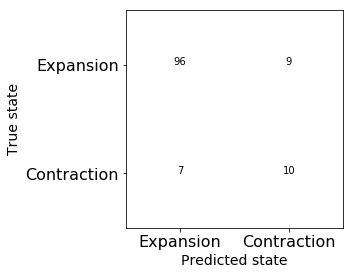

In [426]:
def plot_confusion_matrix(cnf_matrix, class_labels, title='Confusion Matrix', cmap=plt.cm.Blues):
    import itertools
        
    fig, ax = plt.subplots(nrows=1)
    ax.imshow(cnf_matrix, interpolation='nearest', cmap=cmap, alpha=0)
    #plt.axis('off')
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    ax.set_xticklabels(class_labels, fontsize=16)
    ax.set_yticklabels(class_labels, fontsize=16)
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.annotate(str(cnf_matrix[i, j]), xy=(j, i), horizontalalignment='center')
        
        
    ax.set_ylabel('True state', fontsize=14)
    ax.set_xlabel('Predicted state', fontsize=14)
    # ax.set_title(title, fontsize=20)
    ax.grid(False)
    
cnf_matrix = confusion_matrix(test['D_NBER_3'], 
                              all_predictions_topics[2]['p1'].as_data_frame() > 0.02)

plot_confusion_matrix(cnf_matrix, ['Expansion', 'Contraction'])
plt.savefig('confusion_matrix.png', format='png', dpi=600, transparent=False,
           bbox_inches='tight')
plt.show()

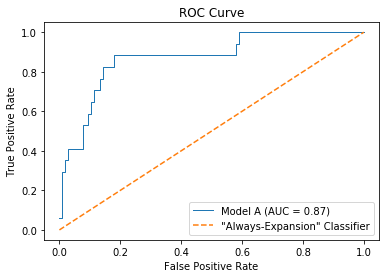

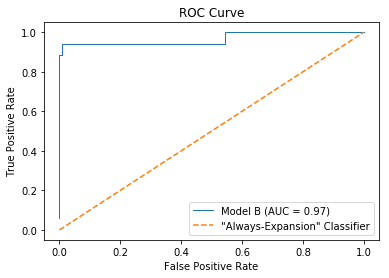

In [447]:
def plot_roc_curve(y_test, y_pred_proba, classifier_label):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
    roc_auc = auc(fpr, tpr)
    
    figure, ax = plt.subplots(1,1)
    
    # if multiple_plots:
    
    ax.plot(fpr, tpr, lw=1, label = classifier_label + ' (AUC = %.2f)' %(roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
                boxstyle='round,pad=0.3', fc='darkorange', alpha=0.5,
            )
    
#     for thres in [0.3, 0.5, 0.6]:
#         idx = np.where(np.round(thresholds, 2) == thres)[0][0]
#         threshold = np.round(thresholds[idx], 2)
#         ax.annotate('Threshold = ' + str(thres), xy=(fpr[idx], tpr[idx]),
#                 xytext=(fpr[idx]-0.12, tpr[idx]+0.06),
#                 arrowprops=dict(facecolor='gray', shrink=5, headwidth=2), horizontalalignment='left',
#                     fontsize=8
#                    )
               
    ax.plot([0, 1], [0, 1], linestyle='--', label='"Always-Expansion" Classifier')
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    ax.set_title('ROC Curve')
    plt.legend(frameon=True, loc='lower right')
    

recession_probs_A = all_predictions_topics[0]['p1'].as_data_frame()
recession_probs_B = all_predictions_topics_CFNAI[0]['p1'].as_data_frame()
 
plot_roc_curve(test['D_NBER'], recession_probs_A, classifier_label='Model A')
plot_roc_curve(test['D_NBER'], recession_probs_B, classifier_label='Model B')

plt.show()

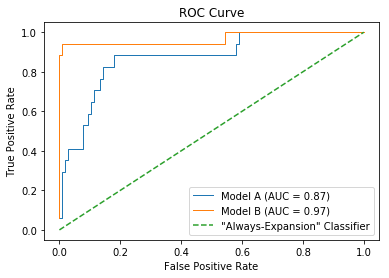

In [451]:
recession_probs_A = all_predictions_topics[0]['p1'].as_data_frame()
recession_probs_B = all_predictions_topics_CFNAI[0]['p1'].as_data_frame()

predictions = {'Model A': recession_probs_A,
              'Model B': recession_probs_B}

# plt.figure(figsize=(15,8))
for model, preds in predictions.items():
    fpr, tpr, thresholds = roc_curve(test['D_NBER'], preds) 
    roc_auc = auc(fpr, tpr)
        
    plt.plot(fpr, tpr, lw=1, label = model + ' (AUC = %.2f)' %(roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', label='"Always-Expansion" Classifier')
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC Curve')
plt.legend(frameon=True, loc='lower right')
plt.savefig('roc_curve.png', format='png', dpi=600, transparent=False,
           bbox_inches='tight')
plt.show()